In [1]:
"""Examine SVD of Radon transform."""

'Examine SVD of Radon transform.'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from common.radon import radon

In [3]:
"""Create explicit Radon transform matrix."""

def create_radon_matrix(img_dims, scanner_properties):
    matrix_dims = (
        scanner_properties["views"] * scanner_properties["detector_count"],
        np.prod(img_dims),
    )

    # Set up Radon transform matrix
    radon_matrix = np.zeros(matrix_dims)

    for j in range(matrix_dims[1]):
        # Create a vectorised blank image with one white pixel equal to current column index
        img = np.zeros(matrix_dims[1])
        img[j] = 1

        # Reshape and perform Radon transform
        img = img.reshape(img_dims, order="F")
        sinogram = radon(img=img, **scanner_properties)
        radon_matrix[:, j] = sinogram.reshape(matrix_dims[0])

    return radon_matrix

In [4]:
"""Create Radon matrix for a small 32 x 32 image."""

scanner_properties = {
    "views": 32,
    "angle": np.pi,
    "detector_count": 32,
    "detector_spacing": 1,
    "beam_geometry": "parallel",
}
img_dims = (32, 32)
sino_dims = (scanner_properties["views"], scanner_properties["detector_count"])

radon_matrix = create_radon_matrix(img_dims, scanner_properties)

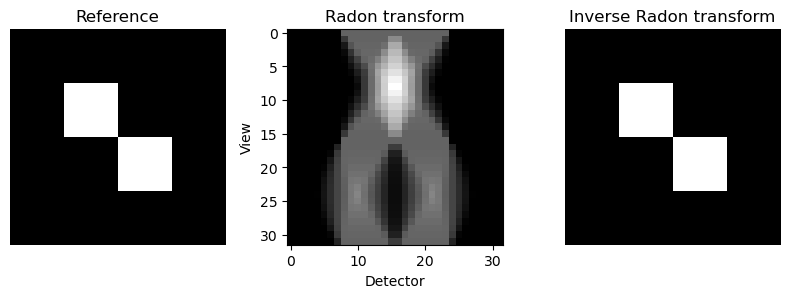

In [5]:
"""Test explicit Radon transform matrix on indicator function"""

f = np.zeros(img_dims)
f[8:16, 8:16] = 1
f[16:24, 16:24] = 1

g = np.reshape(radon_matrix @ f.ravel(), sino_dims)

# Get SVD of Radon transform
U, W, Vt = np.linalg.svd(radon_matrix, full_matrices=False)
Winv = np.linalg.inv(np.diag(W))

# Perform inverse Radon transform using SVD
f_hat = (Vt.T @ Winv @ U.T @ g.ravel()).reshape(img_dims)

plt.figure(figsize=(8, 6))
plt.subplot(1, 3, 1)
plt.imshow(f, cmap="gray")
plt.title("Reference")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(g, cmap="gray")
plt.title("Radon transform")
plt.xlabel("Detector")
plt.ylabel("View")
plt.subplot(1, 3, 3)
plt.imshow(f_hat, cmap="gray")
plt.axis("off")
plt.title("Inverse Radon transform")
plt.tight_layout()
plt.show()

In [6]:
"""Create a small Radon matrix for visualising SVD."""

scanner_properties = {
    "views": 8,
    "angle": np.pi,
    "detector_count": 8,
    "detector_spacing": 1,
    "beam_geometry": "parallel",
}
img_dims = (8, 8)
sino_dims = (scanner_properties["views"], scanner_properties["detector_count"])

radon_matrix = create_radon_matrix(img_dims, scanner_properties)
U, W, Vt = np.linalg.svd(radon_matrix, full_matrices=False)

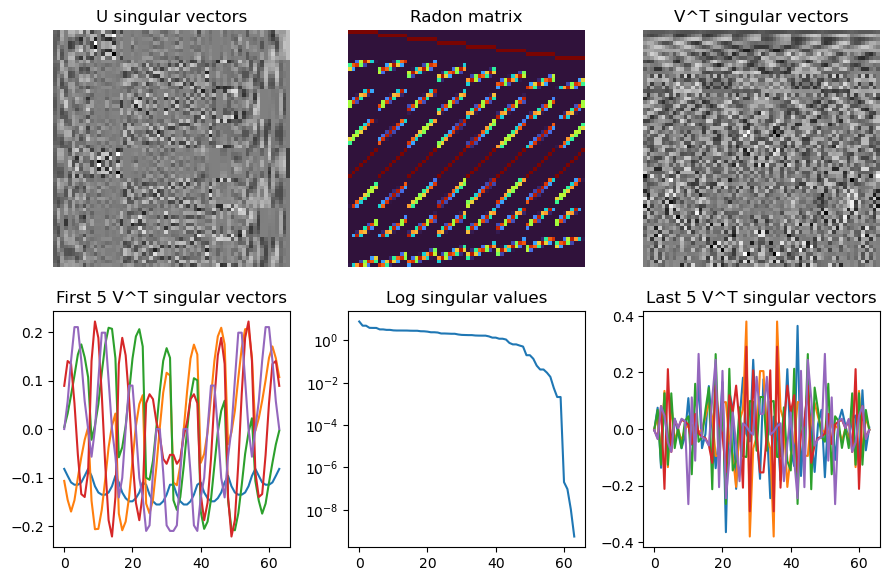

In [7]:
"""Visualise Radon transform matrix SVD."""

fig = plt.figure(figsize=(9, 6))
plt.subplot(2, 3, 1)
plt.imshow(U, cmap="gray")
plt.title("U singular vectors")
plt.axis("off")
plt.subplot(2, 3, 2)
plt.imshow(radon_matrix, cmap="turbo")
plt.title("Radon matrix")
plt.axis("off")
plt.subplot(2, 3, 3)
plt.imshow(Vt, cmap="gray")
plt.title("V^T singular vectors")
plt.axis("off")

plt.subplot(2, 3, 4)
for i in range(5):
    plt.plot(Vt[i, :])
plt.gca().set_box_aspect(1)
plt.title("First 5 V^T singular vectors")

plt.subplot(2, 3, 5)
plt.semilogy(W.flatten())
plt.title("Log singular values")
plt.gca().set_box_aspect(1)

plt.subplot(2, 3, 6)
for i in range(Vt.shape[0] - 5, Vt.shape[0]):
    plt.plot(Vt[i, :])
plt.gca().set_box_aspect(1)
plt.title("Last 5 V^T singular vectors")

plt.tight_layout()
plt.show()

In [8]:
"""Determine how singular values change with number of views"""

scanner_properties = {
    "angle": np.pi,
    "detector_count": 64,
    "detector_spacing": 1,
    "beam_geometry": "parallel",
}
img_dims = (64, 64)

views = [2, 15, 30, 45, 60, 75, 90, 105, 130, 145, 160, 180]
sing_vals = []

for idx, view in enumerate(views):
    # Update scanner properties
    scanner_properties["views"] = view
    sino_dims = (scanner_properties["views"], scanner_properties["detector_count"])

    # Get Radon matrix and SVD
    radon_matrix = create_radon_matrix(img_dims, scanner_properties)
    _, W, _ = np.linalg.svd(radon_matrix)
    sing_vals.append(W)
    print(f"{view} views: condition number {np.linalg.cond(radon_matrix)}")

2 views: condition number 29228103.01630646
15 views: condition number 14641.65473528656
30 views: condition number 512995522.39925057
45 views: condition number 1343705.1195802658
60 views: condition number 21478090781.299225
75 views: condition number 253330.0324564582
90 views: condition number 186865.99802341213
105 views: condition number 130447.04170883374
130 views: condition number 120547.09473833075
145 views: condition number 119507.28351872679
160 views: condition number 115834.25774166537
180 views: condition number 111336.74066559556


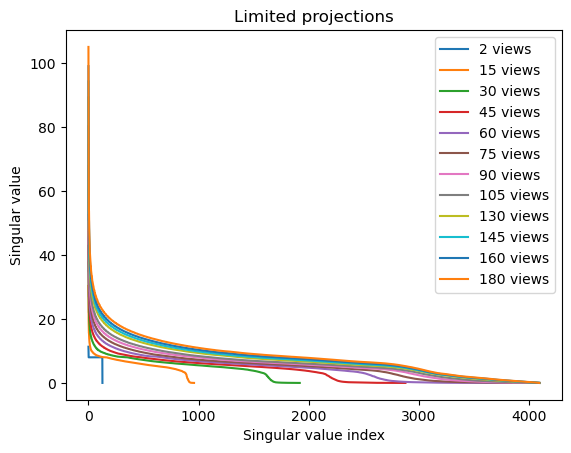

In [9]:
"""Visualise singular values for different numbers of views"""

for idx in range(len(views)):
    plt.plot(sing_vals[idx], label=f"{views[idx]} views")

plt.xlabel("Singular value index")
plt.ylabel("Singular value")
plt.title("Limited projections")
plt.legend()
plt.show()

In [10]:
"""Determine how singular values change with maximum angle"""

scanner_properties = {
    "views": 45,
    "detector_count": 64,
    "detector_spacing": 1,
    "beam_geometry": "parallel",
}
img_dims = (64, 64)

angles = [2, 15, 30, 45, 60, 75, 90, 105, 130, 145, 160, 180]
sing_vals = []

for idx, angle in enumerate(angles):
    # Update scanner properties
    scanner_properties["angle"] = angle / 180 * np.pi
    sino_dims = (scanner_properties["views"], scanner_properties["detector_count"])

    # Get Radon matrix and SVD
    radon_matrix = create_radon_matrix(img_dims, scanner_properties)
    _, W, _ = np.linalg.svd(radon_matrix)
    sing_vals.append(W)
    print(f"Angle {angle}: condition number {np.linalg.cond(radon_matrix)}")

Angle 2: condition number 2.24617750921364e+17
Angle 15: condition number 9799687444629604.0
Angle 30: condition number 25306700.145072386
Angle 45: condition number 1353666.7283463094
Angle 60: condition number 956026.6541461744
Angle 75: condition number 478662.8196287604
Angle 90: condition number 282491.87838685757
Angle 105: condition number 4501492.262403626
Angle 130: condition number 1409889.1101500038
Angle 145: condition number 1447923.0542502368
Angle 160: condition number 838316.7549377462
Angle 180: condition number 1343705.1195802658


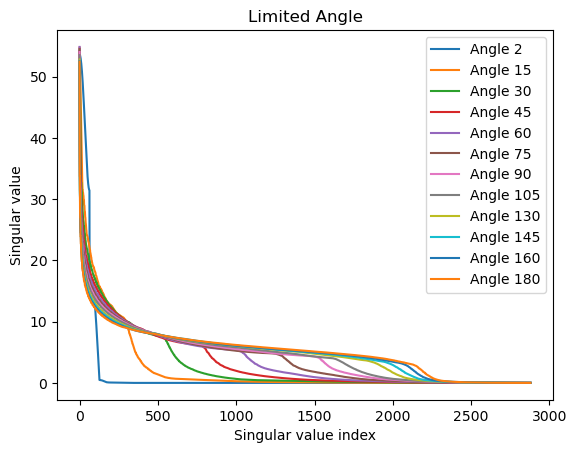

In [11]:
"""Visualise singular values for different maximum angles"""

for idx in range(len(angles)):
    plt.plot(sing_vals[idx], label=f"Angle {angles[idx]}")

plt.xlabel("Singular value index")
plt.ylabel("Singular value")
plt.title("Limited Angle")
plt.legend()
plt.show()